In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.cluster.hierarchy import linkage, fcluster
from itertools import product
from tqdm import tqdm

In [49]:
view1 = pd.read_csv('clusters/GO_BP-clusters.csv')
view2 = pd.read_csv('clusters/GO_MF-clusters.csv')
view3 = pd.read_csv('clusters/GO_CC-clusters.csv')
view4 = pd.read_csv('clusters/HPO-clusters.csv')
mofa = pd.read_csv('clusters/mofa-clusters.csv')

clusterings = {
    'GO_BP': view1,
    'GO_MF': view2,
    'GO_CC': view3,
    'HPO': view4,
    'MOFA': mofa
}

In [82]:
def compute_nmi_matrix(clusterings, k):
    # Compute pairwise NMI for all views at a specific k value
    views = list(clusterings.keys())
    n_views = len(views)
    nmi_matrix = np.zeros((n_views, n_views))

    for i, view1_name in enumerate(views):
        for j, view2_name in enumerate(views):
            if i == j:
                nmi_matrix[i, j] = 1.0
            else:
                labels1 = clusterings[view1_name][[f'{k}']].values.ravel()
                labels2 = clusterings[view2_name][[f'{k}']].values.ravel()
                nmi_matrix[i, j] = adjusted_mutual_info_score(labels1, labels2)

    return pd.DataFrame(nmi_matrix, index=views, columns=views)

## NMI Heatmap for a specific k

Here we are fixing a number of clusters (k) and comparing each view using NMI.

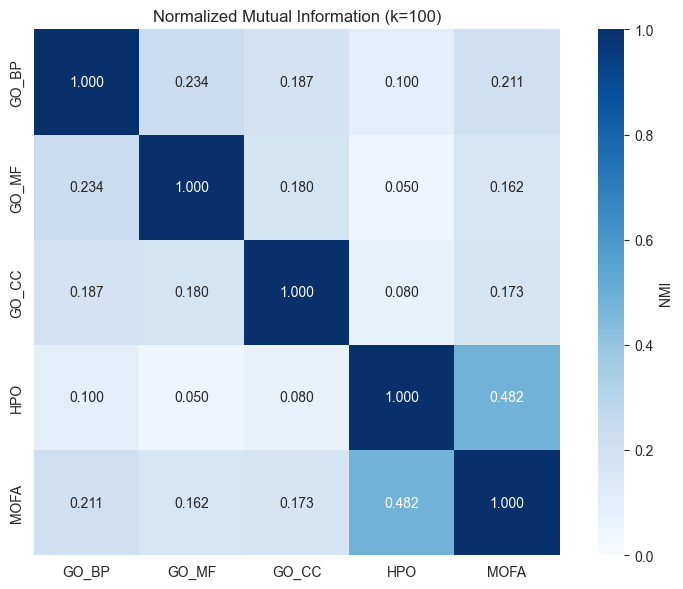

In [83]:
k = 100
nmi_df = compute_nmi_matrix(clusterings, k)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(nmi_df, annot=True, fmt='.3f', cmap='Blues',
            vmin=0, vmax=1, square=True, cbar_kws={'label': 'NMI'})
plt.title(f'Normalized Mutual Information (k={k})')
plt.tight_layout()
plt.show()

In [86]:
def compute_nmi_across_k(clusterings, k_range=range(2, 101)):
    #Compute NMI across all view pairs for each k
    views = list(clusterings.keys())
    n_k = len(k_range)
    n_views = len(views)

    # Create labels for rows/columns
    labels = [f'{view}_k{k}' for view in views for k in k_range]

    # Initialize matrix
    size = n_views * n_k
    nmi_matrix = np.zeros((size, size))

    # Compute NMI for all pairs
    idx = 0
    for view1 in views:
        for k1 in k_range:
            jdx = 0
            for view2 in views:
                for k2 in k_range:
                    if idx == jdx:
                        nmi_matrix[idx, jdx] = 1.0
                    elif idx > jdx:
                        # Use symmetry
                        nmi_matrix[idx, jdx] = nmi_matrix[jdx, idx]
                    else:
                        labels1 = clusterings[view1][str(k1)].values.ravel()
                        labels2 = clusterings[view2][str(k2)].values.ravel()
                        nmi_matrix[idx, jdx] = normalized_mutual_info_score(labels1, labels2)
                    jdx += 1
            idx += 1
            if idx % 50 == 0:
                print(f"Progress: {idx}/{size}")

    return nmi_matrix, labels

In [87]:
full_nmi, label = compute_nmi_across_k(clusterings)

Progress: 50/495
Progress: 100/495
Progress: 150/495
Progress: 200/495
Progress: 250/495
Progress: 300/495
Progress: 350/495
Progress: 400/495
Progress: 450/495


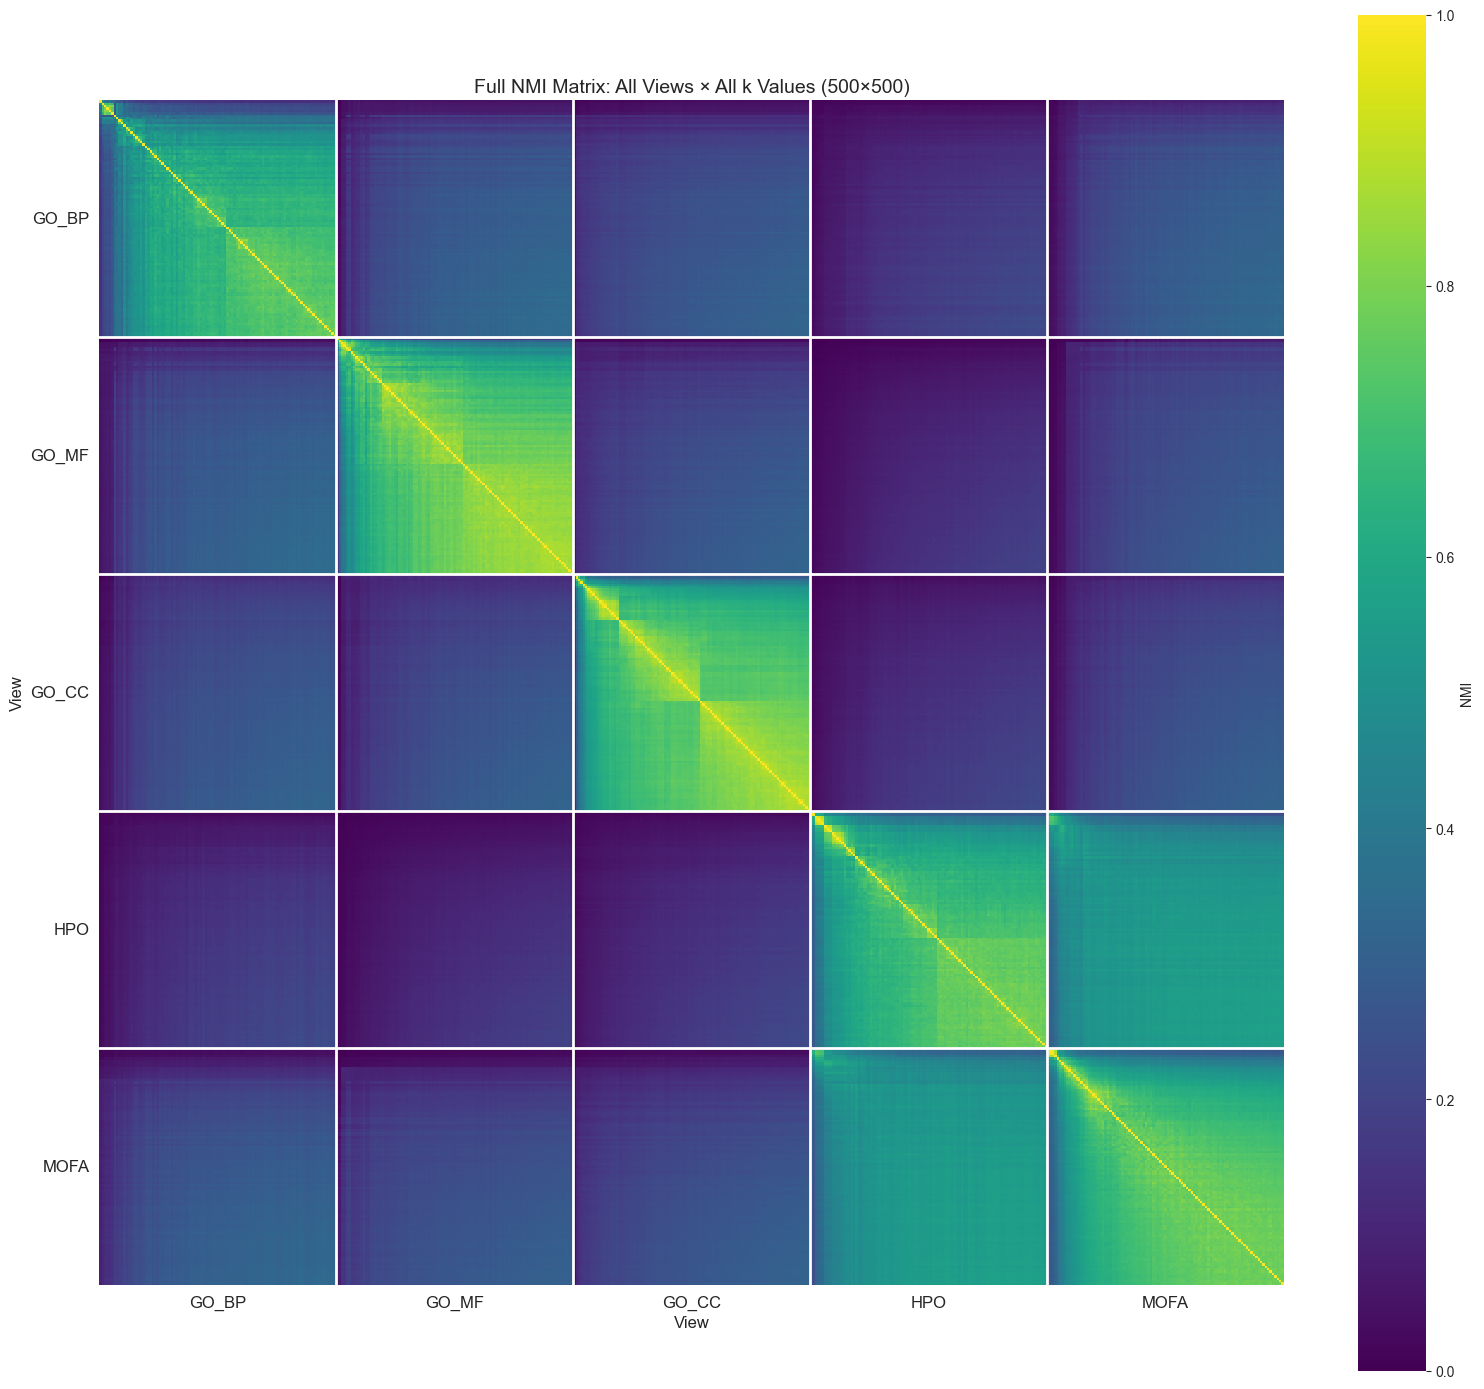

In [88]:
# Plot the full heatmap with view names on axes
plt.figure(figsize=(16, 14))
sns.heatmap(full_nmi, cmap='viridis', vmin=0, vmax=1,
            cbar_kws={'label': 'NMI'}, square=True)
plt.title('Full NMI Matrix: All Views × All k Values (500×500)', fontsize=14)

# Add grid lines to separate views
for i in range(1, len(clusterings)):
    pos = i * 99
    plt.axhline(y=pos, color='white', linewidth=2)
    plt.axvline(x=pos, color='white', linewidth=2)

# Set view names on axes
views = list(clusterings.keys())
tick_positions = [i * 99 + 49.5 for i in range(len(views))]  # Center of each view block
plt.xticks(tick_positions, views, fontsize=12, rotation=0)
plt.yticks(tick_positions, views, fontsize=12, rotation=0)

plt.xlabel('View', fontsize=12)
plt.ylabel('View', fontsize=12)

plt.tight_layout()
plt.show()

In [89]:
def plot_view_pair_heatmap(pair_index):
    views = list(clusterings.keys())
    n_views = len(views)
    n_k = 99  # k from 2 to 100

    # Convert pair_index (1-25) to row and column view indices
    row_view_idx = (pair_index - 1) // n_views
    col_view_idx = (pair_index - 1) % n_views

    row_view = views[row_view_idx]
    col_view = views[col_view_idx]

    # Extract the submatrix for this view pair
    row_start = row_view_idx * n_k
    row_end = row_start + n_k
    col_start = col_view_idx * n_k
    col_end = col_start + n_k

    submatrix = full_nmi[row_start:row_end, col_start:col_end]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(submatrix, cmap='viridis', vmin=0, vmax=1,
                cbar_kws={'label': 'NMI'}, square=True)
    plt.title(f'{row_view} vs {col_view} (Pair Index: {pair_index})', fontsize=14)
    plt.xlabel(f'{col_view} - k values (2 to 100)', fontsize=12)
    plt.ylabel(f'{row_view} - k values (2 to 100)', fontsize=12)

    # Set tick labels for k values (show every 10th)
    tick_positions = range(0, n_k, 10)
    tick_labels = range(2, 101, 10)
    plt.xticks(tick_positions, tick_labels, rotation=0)
    plt.yticks(tick_positions, tick_labels, rotation=0)

    plt.tight_layout()
    plt.show()

    print(f"Pair {pair_index}: {row_view} (rows) vs {col_view} (columns)")
    print(f"Mean NMI: {submatrix.mean():.3f}")
    print(f"Max NMI: {submatrix.max():.3f}")
    print(f"Min NMI: {submatrix.min():.3f}")

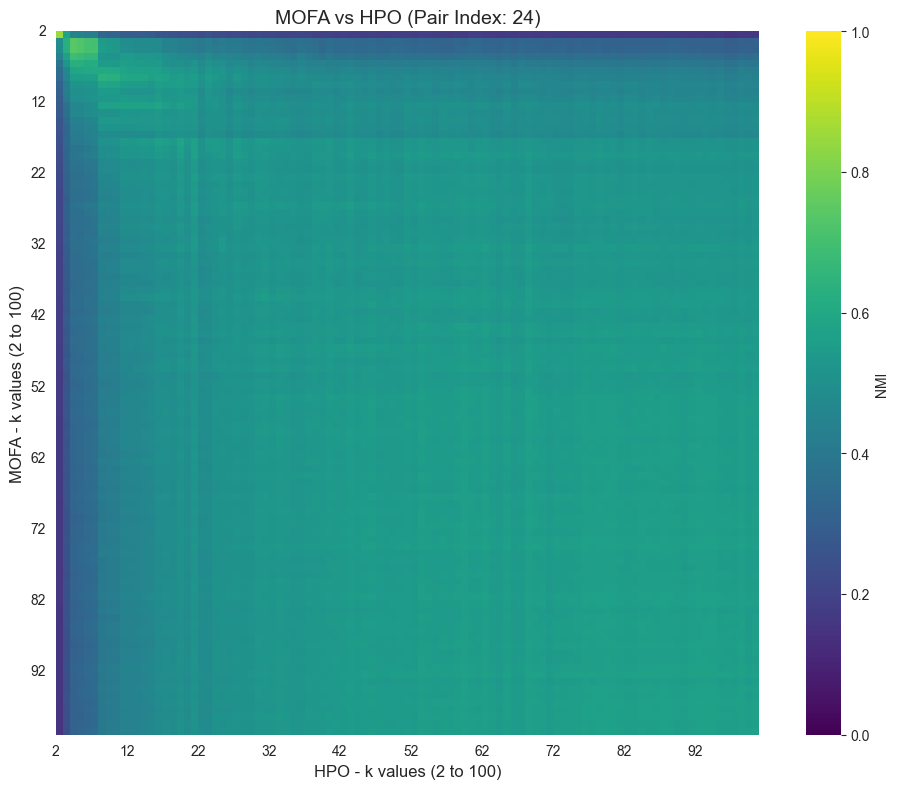

Pair 24: MOFA (rows) vs HPO (columns)
Mean NMI: 0.504
Max NMI: 0.849
Min NMI: 0.151


In [90]:
plot_view_pair_heatmap(24)

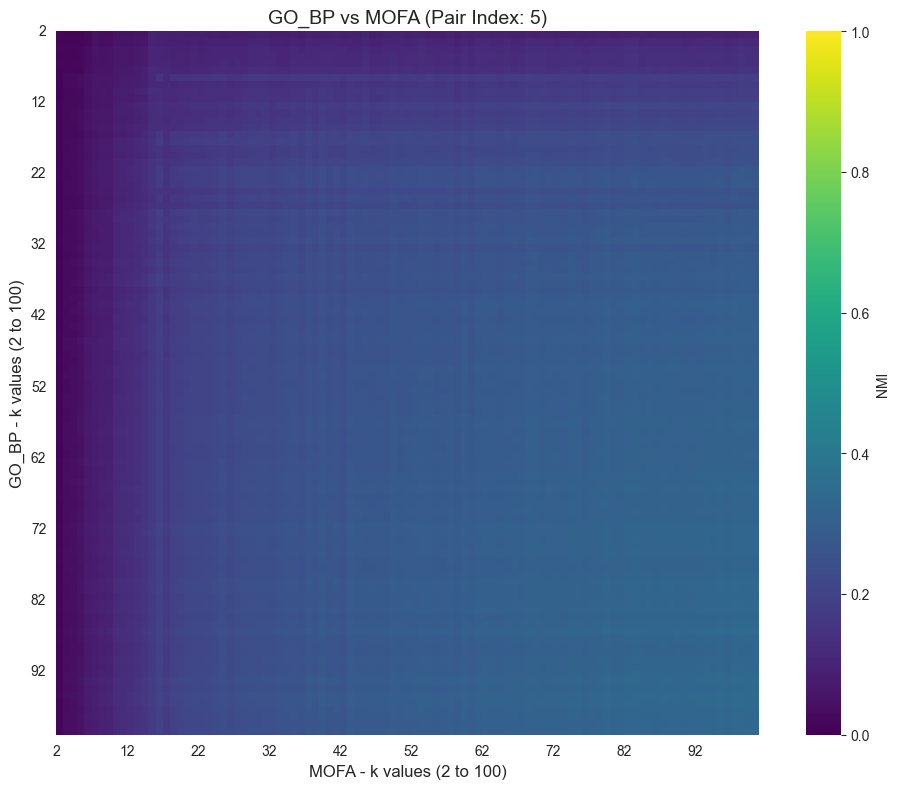

Pair 5: GO_BP (rows) vs MOFA (columns)
Mean NMI: 0.226
Max NMI: 0.344
Min NMI: 0.010


In [91]:
plot_view_pair_heatmap(5)

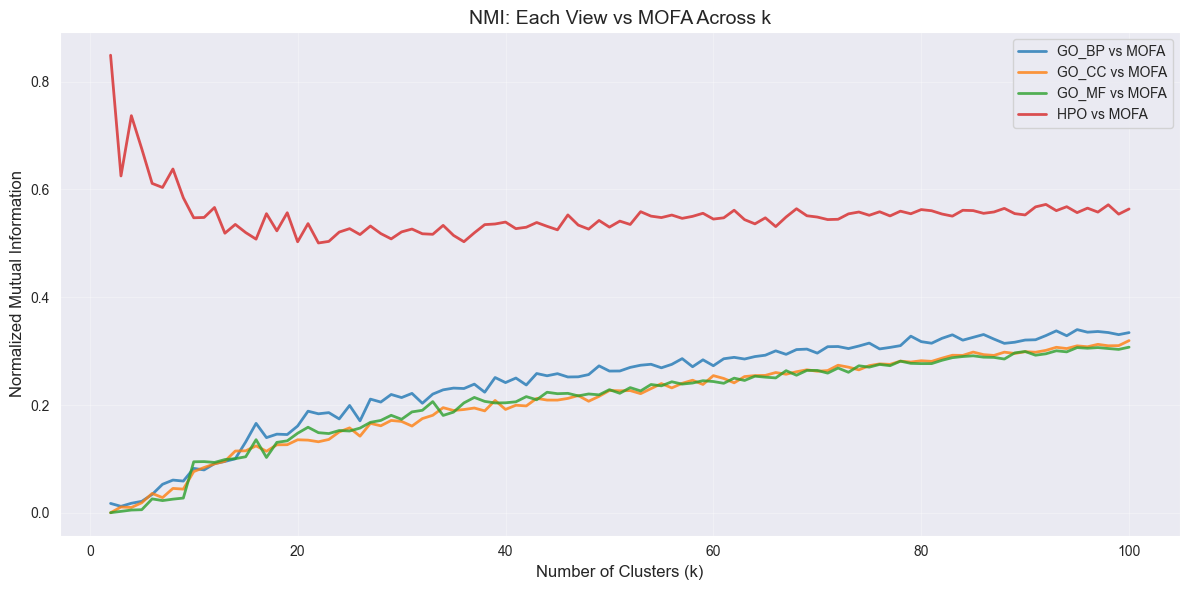

In [70]:
# ONLY VIEWS vs MOFA
views_without_mofa = ['GO_BP', 'GO_CC', 'GO_MF', 'HPO']

plt.figure(figsize=(12, 6))
for view in views_without_mofa:
    nmi_values = []
    for k in range(2, 101):
        labels_view = clusterings[view][f'{k}'].values
        labels_mofa = clusterings['MOFA'][f'{k}'].values
        nmi = normalized_mutual_info_score(labels_view, labels_mofa)
        nmi_values.append(nmi)

    plt.plot(range(2, 101), nmi_values, label=f'{view} vs MOFA', linewidth=2, alpha=0.8)

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Normalized Mutual Information', fontsize=12)
plt.title('NMI: Each View vs MOFA Across k', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

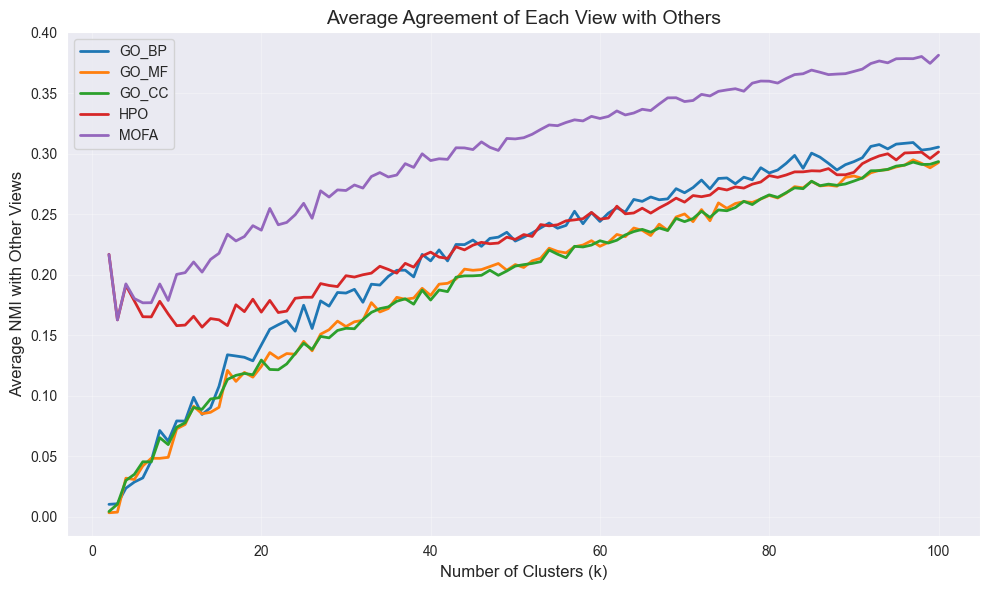

In [71]:
views = list(clusterings.keys())
k_range = range(2, 101)
n_k = len(k_range)

# For each view, compute average NMI with all other views across k
plt.figure(figsize=(10, 6))

for view_idx, view in enumerate(views):
    avg_nmi_values = []

    for k_idx, k in enumerate(k_range):
        # Index in the full_nmi matrix for this view at this k
        row_idx = view_idx * n_k + k_idx

        # Collect NMI values with all other views at the same k
        nmi_values = []
        for other_view_idx, other_view in enumerate(views):
            if other_view_idx != view_idx:
                col_idx = other_view_idx * n_k + k_idx
                nmi_values.append(full_nmi[row_idx, col_idx])

        # Average NMI with all other views
        avg_nmi_values.append(np.mean(nmi_values))

    plt.plot(k_range, avg_nmi_values, label=view, linewidth=2)

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average NMI with Other Views', fontsize=12)
plt.title('Average Agreement of Each View with Others', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

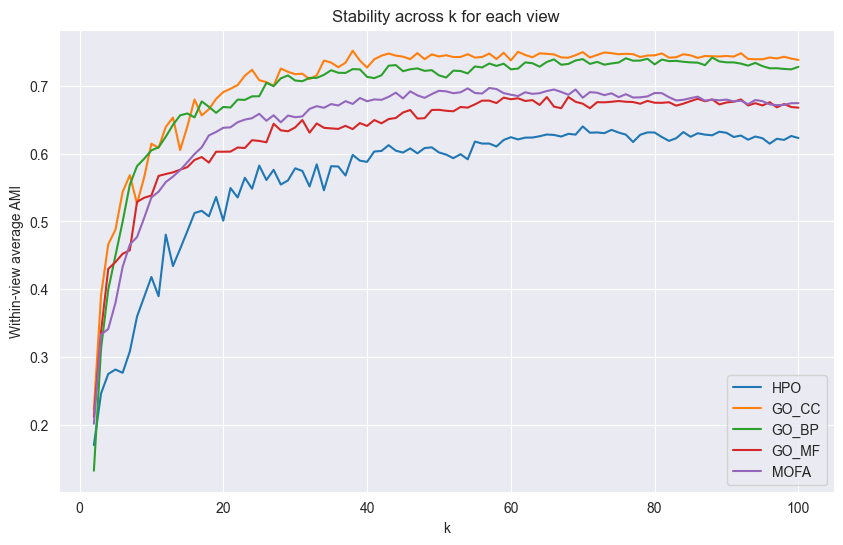

In [103]:
def compute_within_view_stability(nmi_matrix, views, k_range):
    n_views = len(views)
    n_k = len(k_range)

    M = nmi_matrix.reshape(n_views, n_k, n_views, n_k)

    stability = {v: [] for v in views}

    for i, v in enumerate(views):
        for ki in range(n_k):
            # average AMI with same view at all other ks
            vals = []
            for kj in range(n_k):
                if ki == kj:
                    continue
                vals.append(M[i, ki, i, kj])
            stability[v].append(np.mean(vals))

    # Plot
    plt.figure(figsize=(10,6))
    for v in views:
        plt.plot(k_range, stability[v], label=v)

    plt.xlabel("k")
    plt.ylabel("Within-view average AMI")
    plt.title("Stability across k for each view")
    plt.legend()
    plt.show()

# Call
compute_within_view_stability(full_nmi, views, range(2,101))

In [105]:
# Now we measure CONSENSUS between clusterings, for a fixed k value.

def build_coassignment_matrix(clusterings, views_to_include=None, ks_to_include=None):
    """
    Build the co-assignment matrix from multiple clusterings.

    Parameters
    ----------
    clusterings : dict
        {view_name: DataFrame with shape (n_samples, n_k)}
    views_to_include : list of str, optional
        Which views to include (default all)
    ks_to_include : list of int, optional
        Which k values to include (default all ks in clusterings)

    Returns
    -------
    coassign : np.ndarray, shape (n_samples, n_samples)
        Fraction of clusterings in which each pair of samples is in the same cluster
    """
    if views_to_include is None:
        views_to_include = list(clusterings.keys())

    # Determine ks
    if ks_to_include is None:
        # use all columns in first view
        ks_to_include = [int(c) for c in clusterings[views_to_include[0]].columns]

    n_samples = clusterings[views_to_include[0]].shape[0]
    coassign = np.zeros((n_samples, n_samples), dtype=float)
    n_total = 0

    for view in views_to_include:
        df = clusterings[view]
        for k in ks_to_include:
            labels = df[str(k)].values.ravel()
            # build co-assignment for this clustering
            for i in range(n_samples):
                for j in range(i, n_samples):
                    if labels[i] == labels[j]:
                        coassign[i, j] += 1
                        if i != j:
                            coassign[j, i] += 1
            n_total += 1

    coassign /= n_total
    return coassign


def consensus_clustering(coassign_matrix, n_clusters=10, method='average'):
    """
    Compute consensus clusters using hierarchical clustering.

    Parameters
    ----------
    coassign_matrix : np.ndarray
        n_samples x n_samples co-assignment matrix
    n_clusters : int
        Number of consensus clusters
    method : str
        Linkage method for hierarchical clustering (default 'average')

    Returns
    -------
    labels : np.ndarray, shape (n_samples,)
        Consensus cluster labels (1..n_clusters)
    """
    # Convert similarity to distance
    distance = 1.0 - coassign_matrix

    # Condensed distance matrix for linkage
    from scipy.spatial.distance import squareform
    dist_condensed = squareform(distance, checks=False)

    Z = linkage(dist_condensed, method=method)
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    return labels

In [106]:
coassign = build_coassignment_matrix(clusterings,
                                     views_to_include=["HPO","GO_CC","GO_BP","GO_MF","MOFA"],
                                     ks_to_include=range(20,51))  # pick stable ks

# Step 2: compute consensus clusters
n_consensus_clusters = 10
consensus_labels = consensus_clustering(coassign, n_clusters=n_consensus_clusters)

# Step 3: view results
print("Consensus cluster counts:")
print(pd.Series(consensus_labels).value_counts())

Consensus cluster counts:
10    1840
9     1343
1      554
5      334
2      314
7      239
8      175
6      162
4      124
3       98
Name: count, dtype: int64


In [ ]:
# Consensus cluster counts:
# 10    1840
# 9     1343
# 1      554
# 5      334
# 2      314
# 7      239
# 8      175
# 6      162
# 4      124
# 3       98
# Name: count, dtype: int64

# These should be 10 groups of patients with similar cluster assignments across views and ks
# We could analyze these further for clinical relevance, survival, etc.
